# Traffic Sign Detection using CNN (Convolutional Neural Networks)

by Jason Jiang

The Dataset was gathered from the following [Kaggle Link](https://www.kaggle.com/datasets/andrewmvd/road-sign-detection)

It contains 877 images of various real life traffic signs. Each image comes with a XML file containing information about the image and for each traffic sign within the image.

Information includes width and height of the image, the bounding box pixel values of where the traffic sign is on the image, and the traffic sign type.

This project uses TensorFlow techniques to create the CNN for predicting traffic signs.

In [35]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd
import random
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models

In [36]:
traffic_object_df = pd.DataFrame(columns=['img_filename','img_width', 'img_height','obj_name','obj_xmin','obj_ymin','obj_xmax','obj_ymax'])
# NOTE: multiple objects could appear in an image.

In [37]:
# Reading XML files for each images and extract information
for i in range(877):
    tree = ET.parse(r"traffic dataset\annotations\road"+str(i)+r".xml")
    root = tree.getroot()
    img_filename = root.find('filename').text
    img_size = root.find('size')
    img_width = int(img_size.find('width').text)
    img_height = int(img_size.find('height').text)
    traffic_objs = root.findall('object')
    for obj in traffic_objs:
        obj_name = obj.find('name').text
        obj_box = obj.find('bndbox')
        obj_box_xmin = int(obj_box.find('xmin').text)
        obj_box_ymin = int(obj_box.find('ymin').text)
        obj_box_xmax = int(obj_box.find('xmax').text)
        obj_box_ymax = int(obj_box.find('ymax').text)
        obj_row = [img_filename,img_width,img_height,obj_name,obj_box_xmin,obj_box_ymin,obj_box_xmax,obj_box_ymax]
        traffic_object_df.loc[len(traffic_object_df)] = obj_row

In [38]:
label_encoder = LabelEncoder()
traffic_object_df['obj_class'] = label_encoder.fit_transform(traffic_object_df['obj_name'])

Each traffic sign object is converted to a numeric feature.

-    0 = 'crosswalk'

-    1 = 'speedlimit'

-    2 = 'stop'

-    3 = 'trafficlight'
    

In [39]:
img_data = []
for i in range(len(traffic_object_df)):
    img = cv2.imread(r"traffic dataset\images\\"+traffic_object_df['img_filename'][i])[traffic_object_df['obj_ymin'][i]:traffic_object_df['obj_ymax'][i],traffic_object_df['obj_xmin'][i]:traffic_object_df['obj_xmax'][i],[2,1,0]]
    img = cv2.resize(img,(50,50))
    img_data.append(img)
img_data = np.array(img_data)

Some of the signs, like the traffic lights, are not square in the original images. Therefore, they are distorted and stretched when resizing to square image of 50 by 50 pixels.

In [40]:
img_data.shape

(1244, 50, 50, 3)

1244 total traffic signs in dataset.

### Exploratory Data Analysis (EDA)

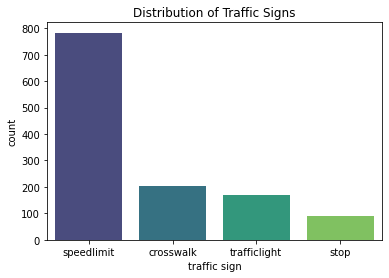

In [41]:
category_counts = traffic_object_df['obj_name'].value_counts()
sns.barplot(x=category_counts.index,y=category_counts.values,palette='viridis')
plt.title('Distribution of Traffic Signs')
plt.xlabel('traffic sign')
plt.ylabel('count')
plt.show()

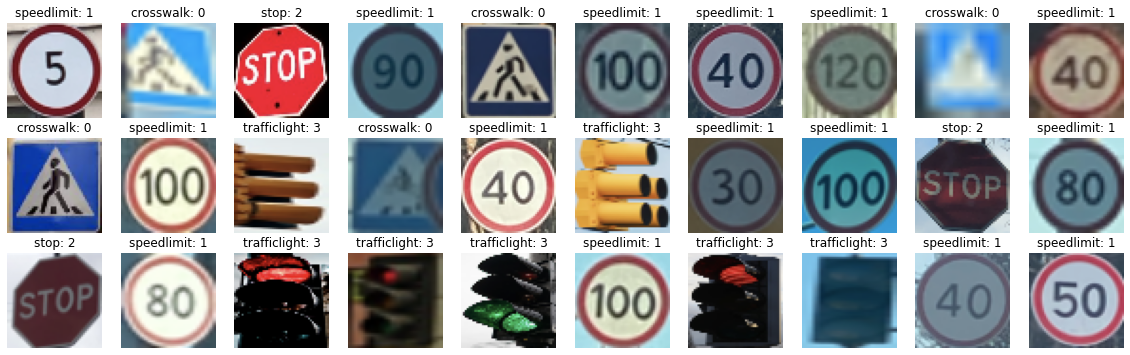

In [26]:
# Visualising the dataset
random.seed(1)
plt.figure(figsize=(20,6))
for i in range(30):
    plt.subplot(3,10,i+1)
    rand_num=random.randint(0,1243)
    plt.imshow(img_data[rand_num])
    plt.axis('off')
    plt.title(f"{traffic_object_df['obj_name'][rand_num]}: {traffic_object_df['obj_class'][rand_num]}")
plt.show()

### CNN Model Training

Splitting the dataset to 80% and 20% training and testing datasets.

Normalising pixel values to be between 0 and 1 is done to speed up process of achieving convergence (When training reaches the state where no significant changes are made).

In [27]:
X_train, X_test, y_train, y_test = train_test_split(img_data, np.array(traffic_object_df['obj_class']), test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [28]:
# Define the CNN model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(25, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(100, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))  # Adjust the output size based on your problem

# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',  # Use categorical_crossentropy for one-hot encoded labels
              metrics=['accuracy'])

CNN_model = model.fit(X_train, y_train, epochs=10, validation_data=(X_test,y_test))

Epoch 1/10
32/32 [==============================] - 1s 14ms/step - loss: 0.9407 - accuracy: 0.6804 - val_loss: 0.5467 - val_accuracy: 0.7510
Epoch 2/10
32/32 [==============================] - 0s 10ms/step - loss: 0.5344 - accuracy: 0.8452 - val_loss: 0.1876 - val_accuracy: 0.9518
Epoch 3/10
32/32 [==============================] - 0s 10ms/step - loss: 0.2123 - accuracy: 0.9437 - val_loss: 0.0935 - val_accuracy: 0.9679
Epoch 4/10
32/32 [==============================] - 0s 10ms/step - loss: 0.1343 - accuracy: 0.9568 - val_loss: 0.0701 - val_accuracy: 0.9839
Epoch 5/10
32/32 [==============================] - 0s 10ms/step - loss: 0.1029 - accuracy: 0.9719 - val_loss: 0.0850 - val_accuracy: 0.9799
Epoch 6/10
32/32 [==============================] - 0s 10ms/step - loss: 0.0847 - accuracy: 0.9819 - val_loss: 0.0430 - val_accuracy: 0.9920
Epoch 7/10
32/32 [==============================] - 0s 10ms/step - loss: 0.0405 - accuracy: 0.9899 - val_loss: 0.0404 - val_accuracy: 0.9799
Epoch 8/10
32

In [29]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

8/8 [==============================] - 0s 2ms/step


In [30]:
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 99.20%


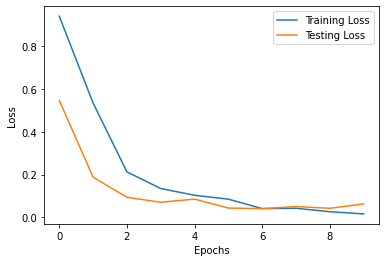

In [31]:
plt.plot(CNN_model.history['loss'], label='Training Loss')
plt.plot(CNN_model.history['val_loss'], label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

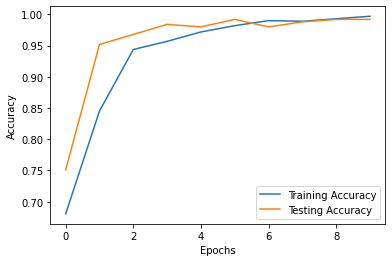

In [32]:
plt.plot(CNN_model.history['accuracy'], label='Training Accuracy')
plt.plot(CNN_model.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:
incorrect_preds = [index for index, (elem1, elem2) in enumerate(zip(y_pred, y_test)) if elem1 != elem2]

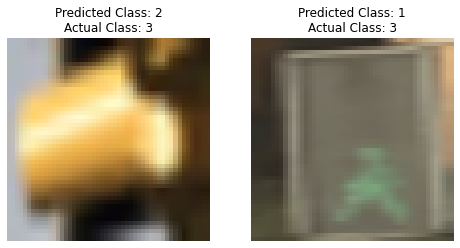

In [34]:
# Incorrect predictions
plt.figure(figsize=(len(incorrect_preds)*4,4))
for i in range(len(incorrect_preds)):
    plt.subplot(1,len(incorrect_preds),i+1)
    plt.imshow(X_test[incorrect_preds[i]])
    plt.axis('off')
    plt.title(f"Predicted Class: {y_pred[incorrect_preds[i]]}\nActual Class: {y_test[incorrect_preds[i]]}")
plt.show()